In [1]:
#imports
import torch.nn.functional as F
import torch
import pandas as pd
import time, sys, os
import tqdm
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Cálculo dos scores

A partir dos embeddings previamente computados (carregados a partir do arquivo 'ref_feat.pickle'), são realizados os cálculos de score para cada teste presente na lista de testes fornecida (ex: veri_test.txt).
Para o cálculo do score é utilizado a *pairwise distance*:

### $\|x\|_{p} = (\sum_{i=1}^{n}|x_i|^{p})^{1/p}$


Para $p=2$ temos a distância euclidiana. Antes do cálculo da *pairwise distance* os vetores são normalizados, o que nos leva a um range de 0 a 2. O score é final é -1 vezes a distância.

Uma possível alternativa para essa métrica é a *cosine similarity*.

In [2]:
def evaluateFromList(embs_file, test_list, print_interval=100, normalize=True):

    df = pd.DataFrame({'label': pd.Series([], dtype='int'),
                       'score': pd.Series([], dtype='float'),
                       'trial': pd.Series([], dtype='str')})

    
    ## Read all lines
    with open(test_list) as f:
        lines = f.readlines()

    feats = torch.load(embs_file)

    print('')
    tstart = time.time()

    ## Read files and compute all scores
    for idx, line in enumerate(lines):

        data = line.split();

        ## Append random label if missing
        if len(data) == 2: data = [random.randint(0,1)] + data

        ref_feat = feats[data[1]].cuda()
        com_feat = feats[data[2]].cuda()

        if normalize:
            ref_feat = F.normalize(ref_feat, p=2, dim=1)
            com_feat = F.normalize(com_feat, p=2, dim=1)

        dist = F.pairwise_distance(ref_feat.unsqueeze(-1), com_feat.unsqueeze(-1).transpose(0,2)).detach().cpu().numpy();

        score = -1 * np.mean(dist);
        
        new_row = {
            'label': int(data[0]),
            'score': score,
            'trial': data[1]+" "+data[2]
        }

        df = df.append(new_row, ignore_index=True)

        if idx % print_interval == 0:
            telapsed = time.time() - tstart
            sys.stdout.write("\rComputing %d of %d: %.2f Hz"%(idx,len(lines),idx/telapsed));
            sys.stdout.flush();

    print('')

    return df;

embs_file = './files/nb_confianca/ref_feat.pickle'
test_list = './files/nb_confianca/veri_test.txt'
df_file = './files/nb_confianca/df.csv'

df = None

if df is None:
    if os.path.exists(df_file):
        df = pd.read_csv(df_file, index_col=0)
    else:
        df = evaluateFromList(embs_file = embs_file, test_list = test_list)
        df.to_csv(df_file)

## Kernel Density Estimation (KDE) vs Histograma

Ao invés de utilizarmos os histogramas das distribuições vamos utilizar as KDEs por representarem uma suaviazação dos histogramas.

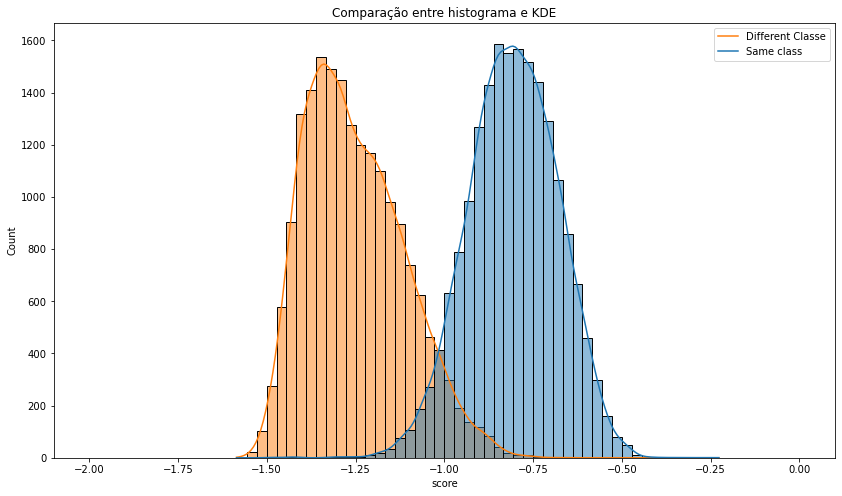

In [3]:
f = plt.figure(figsize=(14, 8))
sns.histplot(data=df, hue='label', hue_order=[1,0], x='score', kde=True, binrange=(-2,0))
plt.legend(labels=['Different Classe', 'Same class'])
plt.title('Comparação entre histograma e KDE')
plt.show()

## Cálculo do KDE para as distribuições dos scores

In [4]:
same_class = np.array(df.loc[df['label'] == 1]['score'])
diff_class = np.array(df.loc[df['label'] == 0]['score'])

x = np.linspace(-2, 0, 201)
x = np.round(x, 2)
kde_same_class = sts.gaussian_kde(same_class).pdf(x)
kde_diff_class = sts.gaussian_kde(diff_class).pdf(x)

## Funções de densidade de probabilidade para os scores de mesma classe e classes diferentes

Pela forma como foram geradas, a "área" embaixo de cada curva vale 1 (a menos de aproximações), podemos entender tais curvas como funções de densidade de probabilidade (PDF). Disso temos que:

- como temos as PDFs, sabemos, para cada score, a "densidade de probabilidade" deste score tanto para o caso de mesma classe (chamaremos de $d_{\text{same_class}}(\text{score})$) quanto para o caso de classes diferentes (chamaremos de $d_{\text{diff_class}}(\text{score})$).

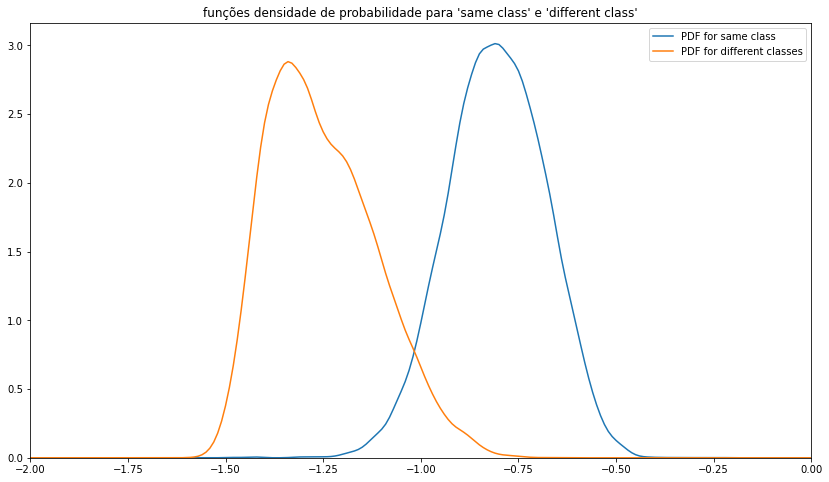

In [5]:
plt.figure(figsize=(14, 8))
# plot the real KDE
plt.plot(x, kde_same_class, label='PDF for same class')
plt.plot(x, kde_diff_class, label='PDF for different classes')
plt.title('funções densidade de probabilidade para \'same class\' e \'different class\'')
plt.ylim(0, None)
plt.xlim(-2, 0)
plt.legend()
plt.show()

## Funções de *confiança*

- sabendo que o teste só pode ser de mesma classe ou de classes diferentes, para cada score temos que:
$d_{\text{same_class}}(\text{score}) + d_{\text{diff_class}}(\text{score}) = 1$
- dessa forma, podemos definir a confiança de determinado score representar um caso de mesma classe por:

<center>$C_{\text{same_class}}(\text{score}) = d_{\text{same_class}} / (d_{\text{same_class}} + d_{\text{diff_class}})$</center>

- é importante notar que $0 \leq C_{\text{same_class}}(\text{score}) \leq 1$

- analogamente, podemos definir:

<center>$C_{\text{diff_class}}(\text{score}) = d_{\text{diff_class}} / (d_{\text{same_class}} + d_{\text{diff_class}})$</center>

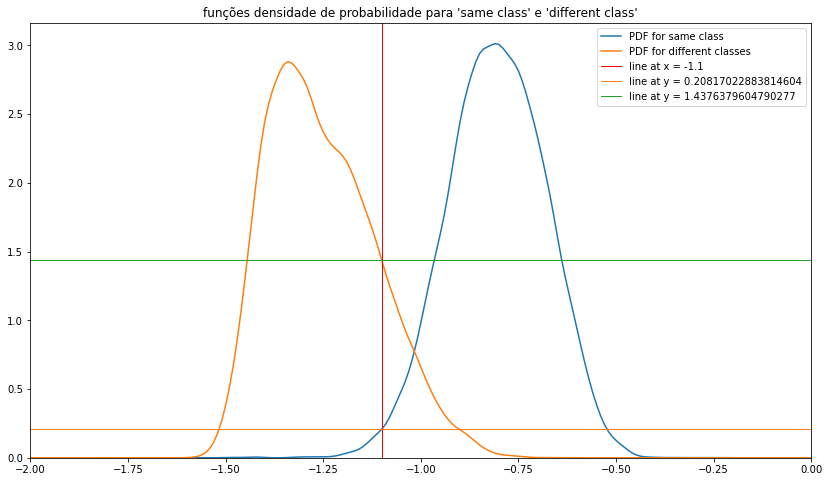

Score arbitrário (xc): -1.1
PDF same class para xc: 0.21
PDF different class para xc: 1.44

Confiança same class em xc: 12.65%
Confiança different class em xc: 87.35%


In [6]:
#cálculo confiança para score arbitrário
plt.figure(figsize=(14, 8))
xc = -1.1

idx = np.argwhere(x == xc).squeeze(axis=1)[0]
xc_same = kde_same_class[idx]
xc_diff = kde_diff_class[idx]

# plot the real KDE
plt.plot(x, kde_same_class, label='PDF for same class')
plt.plot(x, kde_diff_class, label='PDF for different classes')
plt.axvline(x=xc, label='line at x = {}'.format(xc), c='r', lw=1)
plt.axhline(y=xc_same, label='line at y = {}'.format(xc_same), c='C1', lw=1)
plt.axhline(y=xc_diff, label='line at y = {}'.format(xc_diff), c='C2', lw=1)
plt.ylim(0, None)
plt.xlim(-2, 0)
plt.title('funções densidade de probabilidade para \'same class\' e \'different class\'')
plt.legend()
plt.show()

print('Score arbitrário (xc):', xc)
print('PDF same class para xc: {:.2f}'.format(xc_same))
print('PDF different class para xc: {:.2f}'.format(xc_diff))
print('')
print('Confiança same class em xc: {:.2%}'.format(xc_same / (xc_same + xc_diff)))
print('Confiança different class em xc: {:.2%}'.format(xc_diff / (xc_same + xc_diff)))

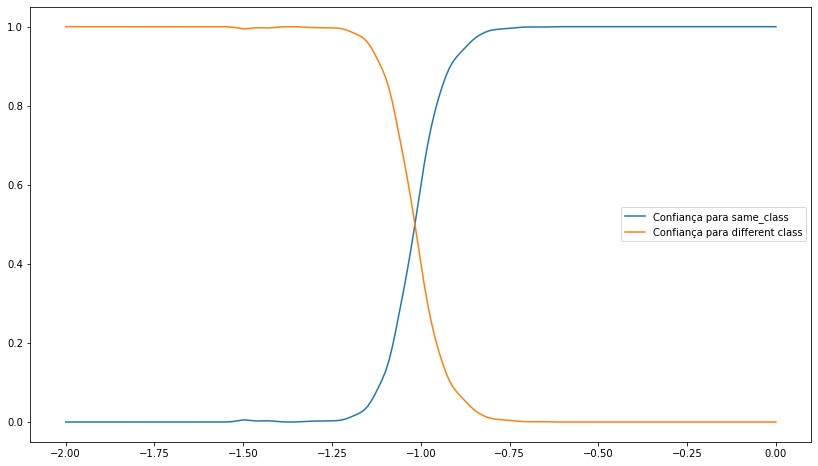

In [7]:
# confianças
c_same = np.ones(len(x))
c_diff = np.ones(len(x))
for i in range(len(x)):
    if (kde_same_class[i] + kde_diff_class[i]) == 0:
        c_same[i] = 1
        c_diff[i] = 1
    else:
        c_same[i] = kde_same_class[i]/(kde_same_class[i] + kde_diff_class[i])
        c_diff[i] = kde_diff_class[i]/(kde_same_class[i] + kde_diff_class[i])

plt.figure(figsize=(14, 8))
plt.plot(x, c_same, label='Confiança para same_class')
plt.plot(x, c_diff, label='Confiança para different class')
plt.legend()
plt.show()

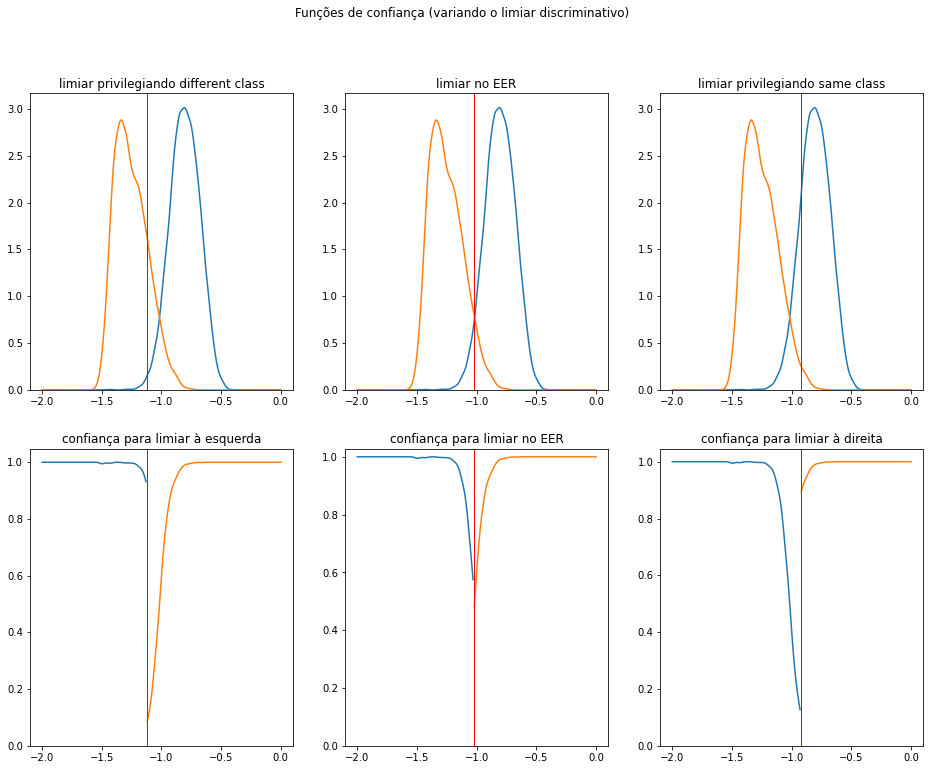

In [8]:
#plots

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,12))
fig.suptitle('Funções de confiança (variando o limiar discriminativo)')
#ax1: PDFs com threshold à esquerda
thresh1 = -1.12
idx1 = np.argwhere(x == thresh1).squeeze(axis=1)[0]
ax1.plot(x, kde_same_class, label='PDF for same class')
ax1.plot(x, kde_diff_class, label='PDF for different classes')
ax1.axvline(x=thresh1, label='line at x = {}'.format(thresh1), c='r', lw=1)
ax1.title.set_text('limiar privilegiando different class')
ax1.axis(ymin=0)

#ax2: PDFs com threshold no centro (EER)
idx_eer = np.minimum(kde_same_class, kde_diff_class).argmax()
thresh_eer = x[idx_eer]
ax2.plot(x, kde_same_class, label='PDF for same class')
ax2.plot(x, kde_diff_class, label='PDF for different classes')
ax2.axvline(x=thresh_eer, label='line at x = {}'.format(thresh_eer), c='r', lw=1)
ax2.title.set_text('limiar no EER')
ax2.axis(ymin=0)

#ax3: PDFs com threshold à direita
thresh3 = -0.92
idx3 = np.argwhere(x == thresh3).squeeze(axis=1)[0]
ax3.plot(x, kde_same_class, label='PDF for same class')
ax3.plot(x, kde_diff_class, label='PDF for different classes')
ax3.axvline(x=thresh3, label='line at x = {}'.format(thresh3), c='r', lw=1)
ax3.title.set_text('limiar privilegiando same class')
ax3.axis(ymin=0)

#ax4: confiança para limiar à esquerda
ax4.plot(x[:idx1], c_diff[:idx1], label='Different class')
ax4.plot(x[idx1:], c_same[idx1:], label='Same class')
ax4.axvline(x=thresh1, label='line at x = {}'.format(thresh1), c='r', lw=1)
ax4.title.set_text('confiança para limiar à esquerda')
ax4.axis(ymin=0)

#ax5: confiança para limiar à esquerda
ax5.plot(x[:idx_eer], c_diff[:idx_eer], label='Different class')
ax5.plot(x[idx_eer:], c_same[idx_eer:], label='Same class')
ax5.axvline(x=thresh_eer, label='line at x = {}'.format(thresh_eer), c='r', lw=1)
ax5.title.set_text('confiança para limiar no EER')
ax5.axis(ymin=0)

#ax6: confiança para limiar à esquerda
ax6.plot(x[:idx3], c_diff[:idx3], label='Different class')
ax6.plot(x[idx3:], c_same[idx3:], label='Same class')
ax6.axvline(x=thresh3, label='line at x = {}'.format(thresh3), c='r', lw=1)
ax6.title.set_text('confiança para limiar à direita')
ax6.axis(ymin=0)

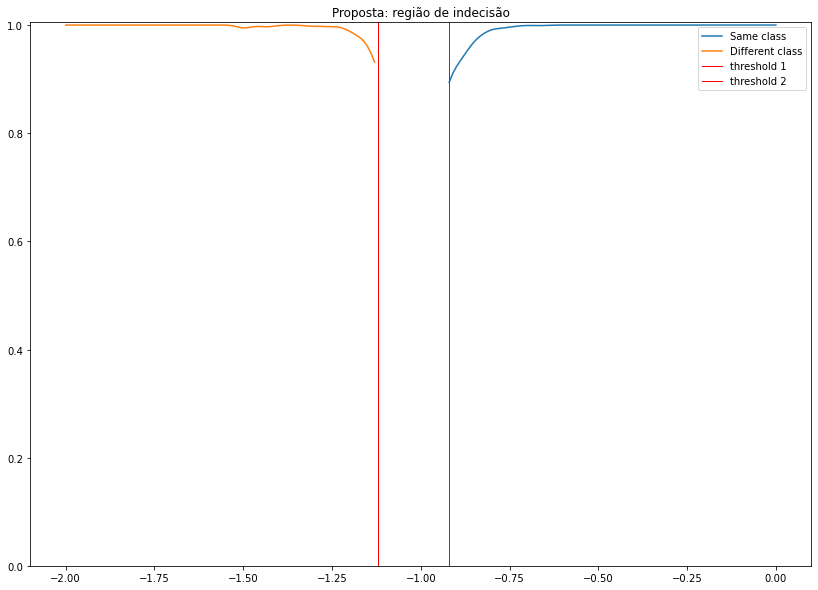

In [9]:
# plot the real KDE
plt.figure(figsize=(14, 10))
plt.plot(x[idx3:], c_same[idx3:], label='Same class')
plt.plot(x[:idx1], c_diff[:idx1], label='Different class')
plt.axvline(x=thresh1, label='threshold 1', c='r', lw=1)
plt.axvline(x=thresh3, label='threshold 2', c='r', lw=1)
plt.axis(ymin=0)

plt.title('Proposta: região de indecisão')
plt.legend()
plt.show()